# Esercizio 2.A
Realizzare un sistema di pulizia immagini (image denoising), basato su una opportuna architettura ad Autoencoder, che prendendo in input un dataset di immagini soggette a "rumore" ne restituisca una versione "pulita".\
(inserire un opportuno filtro di noise per ottenere l'input)\
Utilizzare il dataset [Fashion-MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

In [1]:
import os;
os.environ['KERAS_BACKEND'] = 'jax'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


noise_sd = 0.25
epochs = 100
latent_space = 784

### Import vari e dichiarazione di funzioni

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import ndarray
from keras.api import layers, models
from keras.api.utils import plot_model
from keras.api.layers import LeakyReLU
from keras.api.callbacks import EarlyStopping

def display_images(images:np.ndarray):
    totals = images.shape[0]

    f, ax = plt.subplots(1, totals)
    f.set_size_inches(120, 40)
    plt.gray()
    for i in range(totals):
        ax[i].imshow(images[i])
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    plt.show()

def normalize_pixels(dataset:ndarray) -> ndarray:
    return dataset.astype('float32') / 255


### Dataset

In [3]:
from keras.api.datasets import fashion_mnist as dataset

(trainX, _), (testX, _) = dataset.load_data()
trainX = normalize_pixels(trainX)
testX = normalize_pixels(testX)
if len(trainX.shape[1:]) == 2:
    trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], trainX.shape[2], 1))
    testX = testX.reshape((testX.shape[0], testX.shape[1], testX.shape[2], 1))


### Modello

In [4]:
kernel = (3, 3)
encoder = models.Sequential([
    layers.Input(shape=trainX.shape[1:]),
    layers.GaussianNoise(noise_sd),
    layers.Conv2D(16, kernel, activation=LeakyReLU(), padding='valid'),
    layers.Conv2D(16, kernel, activation=LeakyReLU(), padding='valid'),
    layers.Conv2D(24, kernel, activation=LeakyReLU(), padding='same'),
    layers.Conv2D(24, kernel, activation=LeakyReLU(), padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(48, kernel, activation=LeakyReLU(), padding='same'),
    layers.Conv2D(48, kernel, activation=LeakyReLU(), padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(96, kernel, activation=LeakyReLU(), padding='same'),
    layers.Conv2D(96, kernel, activation=LeakyReLU(), padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(latent_space, activation=LeakyReLU())
])
decoder = models.Sequential([
    layers.Dense(864, activation=LeakyReLU()),
    layers.Reshape((3,3,96)),
    layers.Conv2DTranspose(96, kernel, activation=LeakyReLU(), padding='same', strides=(2, 2)),
    layers.Conv2DTranspose(96, kernel, activation=LeakyReLU(), padding='same'),
    layers.Conv2DTranspose(48, kernel, activation=LeakyReLU(), padding='same', strides=(2, 2)),
    layers.Conv2DTranspose(48, kernel, activation=LeakyReLU(), padding='same'),
    layers.Conv2DTranspose(24, kernel, activation=LeakyReLU(), padding='same', strides=(2, 2)),
    layers.Conv2DTranspose(24, kernel, activation=LeakyReLU(), padding='same'),
    layers.Conv2DTranspose(16, kernel, activation=LeakyReLU(), padding='valid'),
    layers.Conv2DTranspose(testX.shape[-1], kernel, activation='sigmoid', padding='valid',),
])
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile("adam", loss="mse")
autoencoder.save('model_denoise.keras')

print(f"{autoencoder.count_params():,}")
#plot_model(encoder, to_file='model_denoise.png', show_shapes=True, show_layer_names=True)
#raise Exception("woof")

2024-09-06 17:54:23.551536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 17:54:23.562104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 17:54:23.565104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1,770,977


### Training

In [5]:
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)
history = autoencoder.fit(trainX, trainX, epochs=epochs, batch_size=200, shuffle=True, validation_split=0.1, callbacks=[earlystopping])

Epoch 1/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0721 - val_loss: 0.0185
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0182 - val_loss: 0.0163
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0149 - val_loss: 0.0136
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0123 - val_loss: 0.0110
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 9/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 10/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 11/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0097 - val_loss: 0.0087
Epoch 12/100
270/270 ━━━━━━━━

### Display

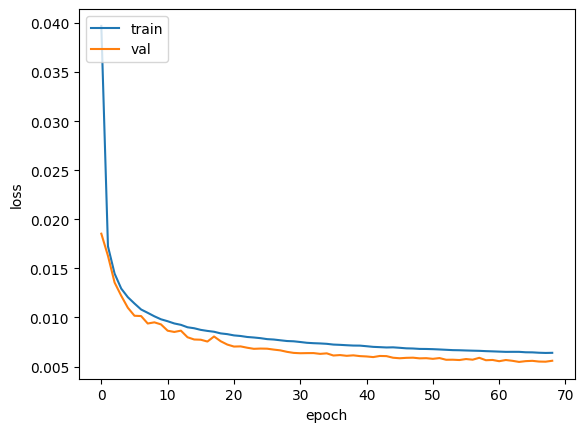

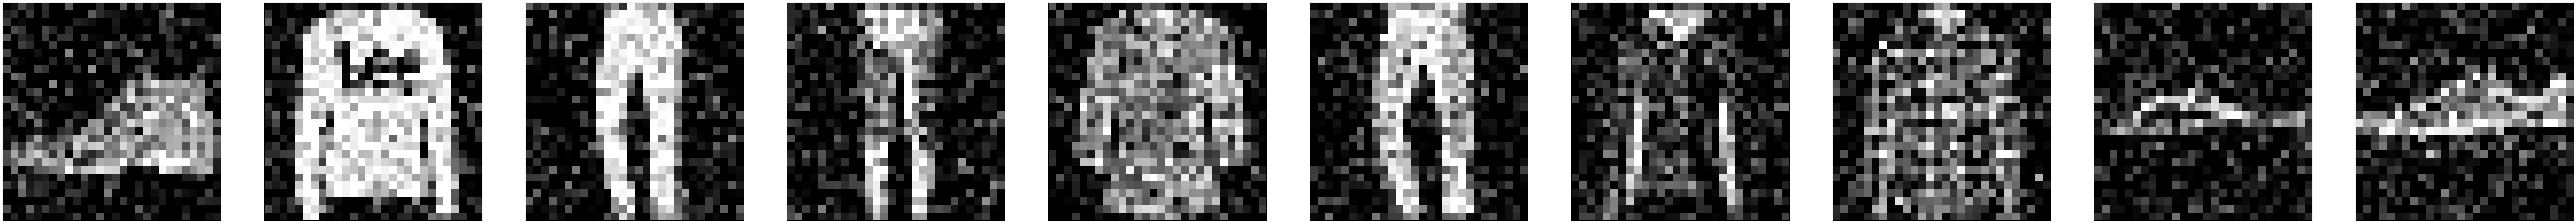

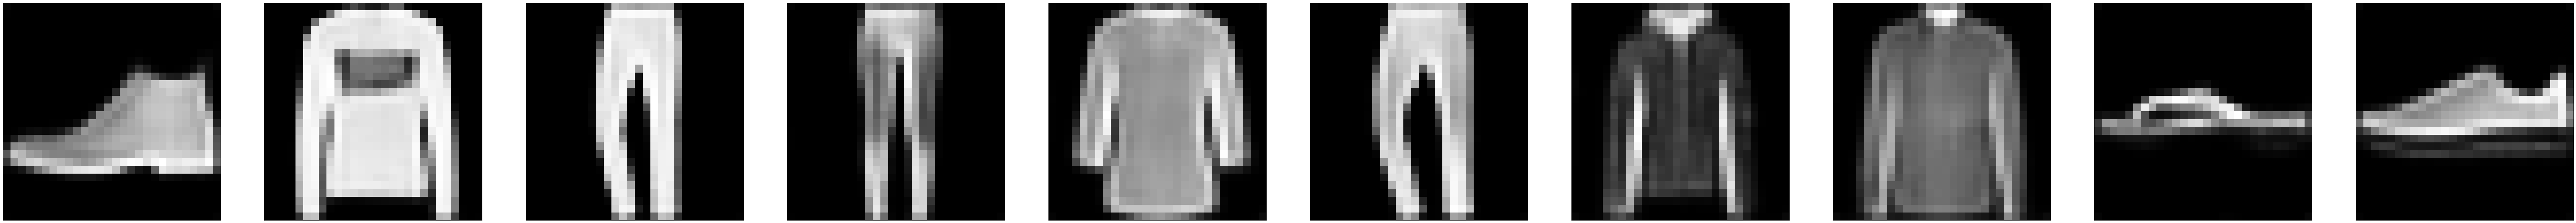

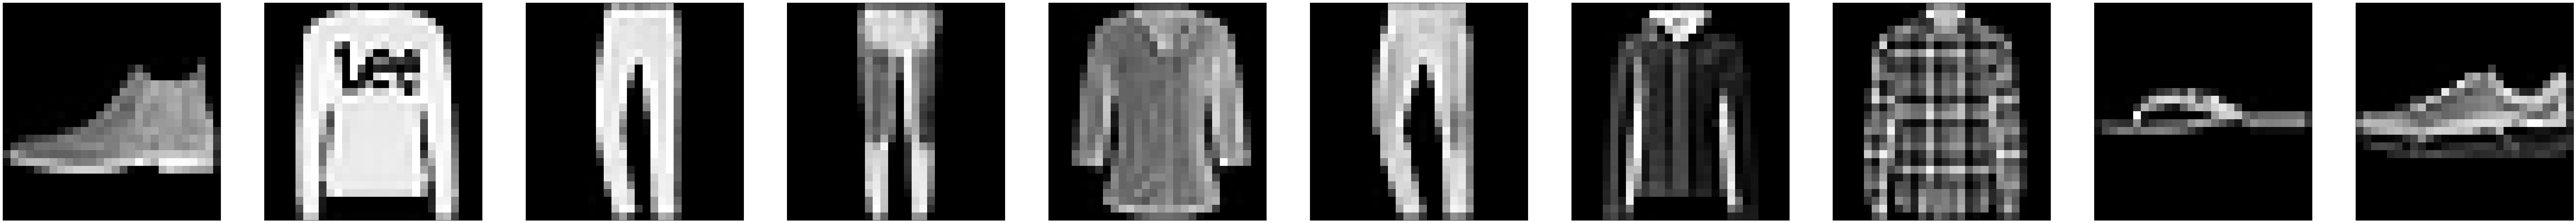

In [10]:
if True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

n = 10  # How many images we will display
images = testX[0:n]
noised = np.random.normal(0., 0.2, images.shape) + images
noised = np.clip(noised, 0., 1.)
predicted = autoencoder.predict(noised, verbose=0)

display_images(noised)
display_images(predicted)
display_images(images)